In [1]:
# Imports
import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

#import logging
#log = logging.getLogger(__name__)

try:
    import covid19_inference as cov19
    print("Option 1")
except ModuleNotFoundError:
    sys.path.append("../")
    import covid19_inference as cov19
    print("Option 2")

Option 2


In [40]:
# Fetch the JHU data
jhu_df = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
jhu_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,5075,5103,5154,5184,5198,5227,5257,5270,5327,5358
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,15841,16002,16176,16251,16346,16513,16653,16798,16981,17128
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1696,1712,1723,1729,1730,1738,1760,1778,1793,1805
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2113,2130,2144,2151,2162,2170,2188,2198,2212,2223
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,5219,5264,5292,5304,5308,5320,5376,5411,5439,5462


In [41]:
texas_df = jhu_df[jhu_df["Province_State"] == "Texas"]
texas_df = texas_df.drop(labels=["UID", "iso2", "iso3", "code3", "FIPS", "Province_State", "Country_Region", "Lat", "Long_", "Combined_Key"], axis=1)
texas_df = texas_df.rename(columns={"Admin2":"County"})
texas_df = texas_df.set_index(["County"])
texas_df = texas_df.T
texas_df.index = pd.to_datetime(texas_df.index)
texas_df["Texas"] = texas_df.sum(axis=1) # Add the state total
texas_df.to_csv("jhu_tx.csv")

# Use this to read back in later
# pd.read_csv("jhu_tx.csv", index_col=0, parse_dates=True)

# Now get daily new
tx_new_cases = texas_df.diff()

# Filter dataframe for a start date
sdate = datetime.datetime(2020, 3, 1)
tx_new_cases = tx_new_cases.loc[sdate:]

# Now set all 0's after some fixed date equal to NaNs
zero_date = datetime.datetime(2020, 4, 1)
tx_new_cases.loc[zero_date:] = tx_new_cases.loc[zero_date:].replace(0.0, np.nan)

# Now drop NaNs (never mind, do this individually for each county)
# tx_new_cases = tx_new_cases.dropna()

# Clip negatives at zero
tx_new_cases = tx_new_cases.clip(lower=0.0)

In [35]:
tx_new_cases

County,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala,Texas
2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-19,NaN,NaN,213.0,2.0,NaN,2.0,NaN,21.0,1.0,NaN,...,1607.0,NaN,5.0,NaN,NaN,NaN,NaN,3.0,NaN,19269.0
2021-01-20,121.0,NaN,NaN,18.0,10.0,1.0,118.0,27.0,9.0,24.0,...,385.0,48.0,5.0,252.0,90.0,NaN,88.0,43.0,48.0,28095.0
2021-01-21,0.0,13.0,NaN,3.0,13.0,NaN,197.0,4.0,NaN,44.0,...,783.0,150.0,3.0,34.0,51.0,1.0,18.0,1.0,89.0,23317.0
2021-01-22,0.0,5.0,92.0,2.0,12.0,2.0,16.0,21.0,5.0,3.0,...,378.0,14.0,12.0,70.0,NaN,15.0,19.0,35.0,5.0,18918.0


In [42]:
pop_df = pd.read_csv('PopEstimates.csv')
pop_df.head()

,year,FIPS,area_name,total,total_male,total_female,nh_white_total,nh_white_male,nh_white_female,nh_black_total,...,nh_black_female,hispanic_total,hispanic_male,hispanic_female,nh_asian_total,nh_asian_male,nh_asian_female,nh_other_total,nh_other_male,nh_other_female
0,2010,0,State of Texas,25145561,12472280,12673281,11397345,5632646,5764699,2886825,...,1494415,9460921,4763753,4697168,948426,460855,487571,452044,222616,229428
1,2011,0,State of Texas,25567291,12684177,12883114,11473189,5672925,5800264,2948232,...,1525637,9681249,4873297,4807952,995813,484336,511477,468808,231024,237784
2,2012,0,State of Texas,25996722,12899473,13097249,11548679,5712731,5835948,3011317,...,1557750,9905223,4984546,4920677,1045280,508836,536444,486223,239793,246430
3,2013,0,State of Texas,26433242,13118331,13314911,11624174,5752529,5871645,3075723,...,1590409,10132148,5097205,5034943,1096888,534427,562461,504309,248856,255453
4,2014,0,State of Texas,26876429,13340220,13536209,11699326,5791913,5907413,3141271,...,1623699,10361956,5211270,5150686,1150724,561173,589551,523152,258292,264860


In [43]:
# Get list of top 10 most populated counties (really getting 11 total, since includes state total)
top_ten_pop = pop_df[pop_df['year'] == 2020].nlargest(11, ['total'])['area_name'].values.tolist()
top_ten_pop.remove('State of Texas')
top_ten_pop_no_county = [item.split(" County")[0] for item in top_ten_pop]
print(top_ten_pop)

['Harris County', 'Dallas County', 'Tarrant County', 'Bexar County', 'Travis County', 'Collin County', 'Denton County', 'El Paso County', 'Hidalgo County', 'Fort Bend County']


In [47]:
def get_county_data(county_name, pop_threshold=1e-6, trunc_date=None):
    '''
    Given a county name, returns a tuple (daily_new_cases, pop).
    '''
    if county_name == "Texas":
        pop = pop_df[(pop_df['year'] == 2020)&(pop_df['area_name'] == "State of Texas")]['total'].values[0]
    else:
        pop = pop_df[(pop_df['year'] == 2020)&(pop_df['area_name'] == county_name+" County")]['total'].values[0]
        
    # Get county data
    county_new_cases = tx_new_cases[county_name]
    
    #trunc_date = datetime.datetime(2020, 8, 1) # Choose a date to truncate the data at
    
    county_new_cases = county_new_cases.dropna()
    
    # We need to start each county's dataset once the daily new cases achieves some threshold % of the county's population
    data_begin = min(county_new_cases[(county_new_cases/pop) > pop_threshold].index)
    county_new_cases = county_new_cases.loc[data_begin:]
    
    # Truncate if necessary
    if trunc_date != None:
        other_part = county_new_cases.loc[trunc_date:]
        county_new_cases = county_new_cases.loc[:trunc_date]
        return county_new_cases, other_part, pop
    
    return county_new_cases, pop

In [48]:
county_new, other_part, county_pop = get_county_data("Texas", trunc_date=datetime.datetime(2020, 8, 1))

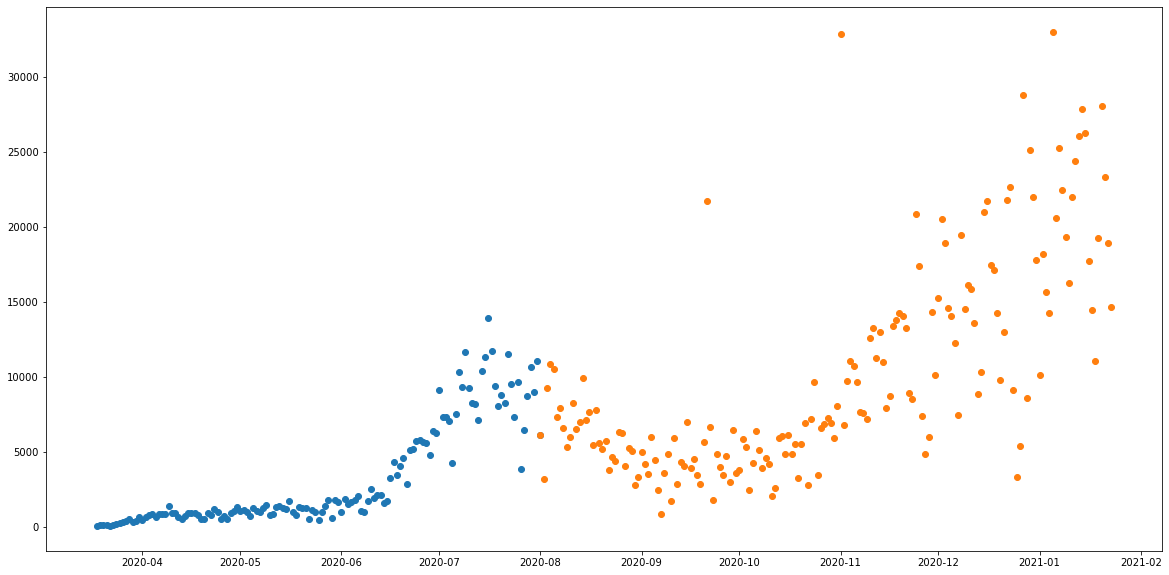

In [52]:
plt.figure(figsize=(20,10))
plt.scatter(county_new.index, county_new.values)
plt.scatter(other_part.index, other_part)
plt.show()

In [15]:
def build_and_calc_map(county_name, pr_len_scale=7.0):
    '''
    Runs a model given a county name.
    '''
    # Get data
    new_cases_obs, county_pop = get_county_data(county_name)
    
    # Setup params
    diff_data_sim = 16
    num_days_forecast = 10
    pr_delay = 10
    #pr_len_scale = 4.0
    #pr_len_scale = 7.0
    #pr_len_scale = 7.0 # Length scale for the GP

    # Stores the model parameters in a dict
    params_model = dict(
        new_cases_obs=new_cases_obs,
        data_begin=min(new_cases_obs.index),
        fcast_len=num_days_forecast,
        diff_data_sim=diff_data_sim,
        N_population=county_pop,
    )

    # Put model together
    with cov19.model.Cov19Model(**params_model) as this_model:

        # Adds the recovery rate mu to the model as a random variable
        mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

        # Create the array of the time dependent infection rate lambda
        #pr_len_scale = pm.Uniform('pr_len_scale', 5.0, 10.0)
        pr_amplitude = pm.Uniform('pr_amplitude', 0.1, 0.7) 
        lambda_t_log = cov19.model.lambda_t_gp(
                            mu,
                            pr_len_scale,
                            pr_amplitude,
                            #model=None,
                            name_lambda_t="lambda_t",
        )

        # This builds a decorrelated prior for I_begin for faster inference.
        prior_I = cov19.model.uncorrelated_prior_I(
            lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
        )

        # Use lambda_t_log and mu as parameters for the SIR model.
        # The SIR model generates the inferred new daily cases.
        new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

        # Delay the cases by a lognormal reporting delay and add them as a trace variable
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=pr_delay,
            pr_median_of_width=0.3,
        )

        # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
        # Also adds the "new_cases" variable to the trace that has all model features.
        new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

        # Define the likelihood, uses the new_cases_obs set as model parameter
        cov19.model.student_t_likelihood(cases=new_cases)
        
        # Now compute map
        map_est = pm.find_MAP()
        
        return (new_cases_obs, county_pop, map_est)

In [16]:
def build_and_calc_advi(county_name):
    '''
    Runs a model given a county name.
    '''
    # Get data
    new_cases_obs, county_pop = get_county_data(county_name)
    
    # Setup params
    diff_data_sim = 16
    num_days_forecast = 10
    pr_delay = 10
    pr_len_scale = 4.0
    #pr_len_scale = 7.0
    #pr_len_scale = 7.0 # Length scale for the GP

    # Stores the model parameters in a dict
    params_model = dict(
        new_cases_obs=new_cases_obs,
        data_begin=min(new_cases_obs.index),
        fcast_len=num_days_forecast,
        diff_data_sim=diff_data_sim,
        N_population=county_pop,
    )

    # Put model together
    with cov19.model.Cov19Model(**params_model) as this_model:

        # Adds the recovery rate mu to the model as a random variable
        mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

        # Create the array of the time dependent infection rate lambda
        #pr_len_scale = pm.Uniform('pr_len_scale', 5.0, 10.0)
        pr_amplitude = pm.Uniform('pr_amplitude', 0.1, 0.7) 
        lambda_t_log = cov19.model.lambda_t_gp(
                            mu,
                            pr_len_scale,
                            pr_amplitude,
                            #model=None,
                            name_lambda_t="lambda_t",
        )

        # This builds a decorrelated prior for I_begin for faster inference.
        prior_I = cov19.model.uncorrelated_prior_I(
            lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
        )

        # Use lambda_t_log and mu as parameters for the SIR model.
        # The SIR model generates the inferred new daily cases.
        new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

        # Delay the cases by a lognormal reporting delay and add them as a trace variable
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=pr_delay,
            pr_median_of_width=0.3,
        )

        # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
        # Also adds the "new_cases" variable to the trace that has all model features.
        new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

        # Define the likelihood, uses the new_cases_obs set as model parameter
        cov19.model.student_t_likelihood(cases=new_cases)
        
        # Now compute map
        #map_est = pm.find_MAP()
        
        advi = pm.fit(method="advi")
        
        
        return (new_cases_obs, county_pop, advi)

# Dallas PPC

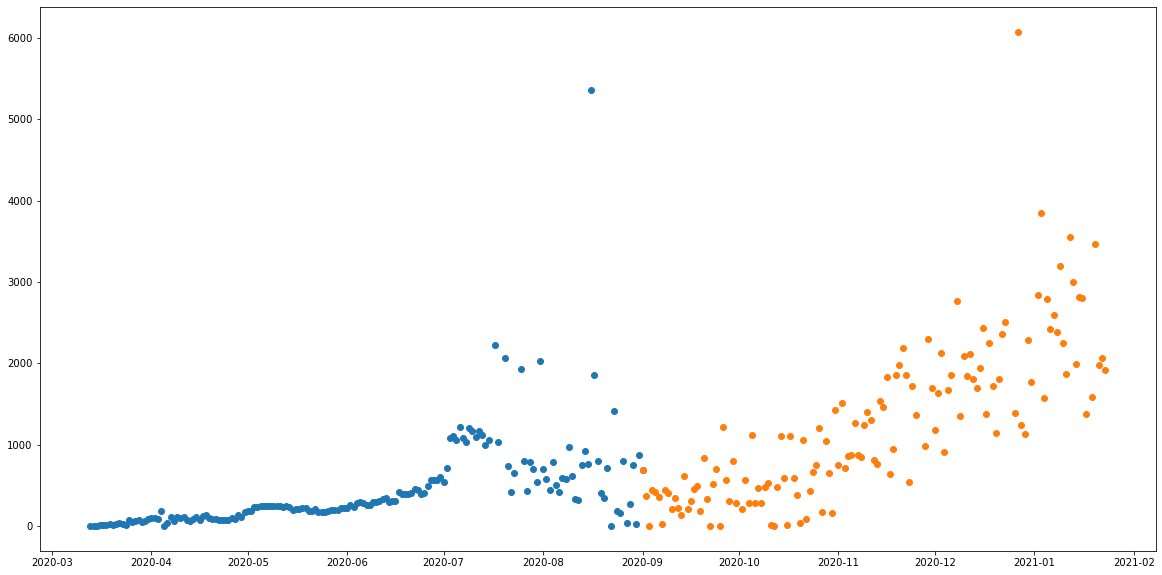

In [54]:
county_name = "Dallas"
new_cases_obs, other_part, county_pop = get_county_data(county_name, trunc_date=datetime.datetime(2020,9,1))

plt.figure(figsize=(20,10))
plt.scatter(new_cases_obs.index, new_cases_obs)
plt.scatter(other_part.index, other_part)
plt.show()

In [58]:
# Get data
#county_name = "Dallas"
#new_cases_obs, county_pop = get_county_data(county_name)
    
# Setup params
diff_data_sim = 16
num_days_forecast = len(other_part)
pr_delay = 10
pr_len_scale = 7.0
#pr_len_scale = 7.0 # Length scale for the GP

# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=min(new_cases_obs.index),
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=county_pop,
    )

    # Put model together
with cov19.model.Cov19Model(**params_model) as this_model:

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # Create the array of the time dependent infection rate lambda
    #pr_len_scale = pm.Uniform('pr_len_scale', 5.0, 10.0)
    pr_amplitude = pm.Uniform('pr_amplitude', 0.1, 0.7) 
    lambda_t_log = cov19.model.lambda_t_gp(
                            mu,
                            pr_len_scale,
                            pr_amplitude,
                            #model=None,
                            name_lambda_t="lambda_t",
        )

    # This builds a decorrelated prior for I_begin for faster inference.
    prior_I = cov19.model.uncorrelated_prior_I(
            lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
        )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=pr_delay,
            pr_median_of_width=0.3,
        )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)
        
    # Now compute map
    #map_est = pm.find_MAP()

    trace = pm.sample(draws=2000, tune=500, cores=1)
    trace2 = pm.save_trace(trace, directory=sys.path[0]+"/ppc_trace/", overwrite=True)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, log_r_t_rotated_, pr_amplitude, mu]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, log_r_t_rotated_, pr_amplitude, mu]


Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 48054 seconds.
INFO     [pymc3] Sampling 2 chains for 500 tune and 2_000 draw iterations (1_000 + 4_000 draws total) took 48054 seconds.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1296 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 1296 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6594387871703027, but should be close to 0.8. Try to increase the number of tuning steps.
WARNING  [pymc3] The acceptance probability does not match the target. It is 0.6594387871703027, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
WARNING  [pymc3] 

In [61]:
pm.trace_to_dataframe(trace).columns

Index(['log_r_t_rotated___0', 'log_r_t_rotated___1', 'log_r_t_rotated___2',
       'log_r_t_rotated___3', 'log_r_t_rotated___4', 'log_r_t_rotated___5',
       'log_r_t_rotated___6', 'log_r_t_rotated___7', 'log_r_t_rotated___8',
       'log_r_t_rotated___9',
       ...
       'new_cases__314', 'new_cases__315', 'new_cases__316', 'new_cases__317',
       'new_cases__318', 'new_cases__319', 'new_cases__320', 'new_cases__321',
       'new_cases__322', 'sigma_obs'],
      dtype='object', length=3241)

In [74]:
def compute_bands(vals, levels=[1.0, 5.5, 12.5, 25, 75, 87.5, 94.5, 99.0]):
    '''
    Given an array with shape (x, y, z) where x is the dimension for samples, y is the 
    dimension for time, and z the dimension variable, computes the corresponding percentile bands for credible intervals.
    '''
    def scoreatpercentile(vals, p):
        return np.percentile(vals, p, axis=0)
    perc = {p:scoreatpercentile(vals,p) for p in levels}
    median = np.median(vals, axis=0)
    perc["median"] = median
    return perc

In [67]:
nsamps, ndays = trace["r_t"].shape

In [75]:
bands = compute_bands(trace["r_t"])

KeyboardInterrupt: 

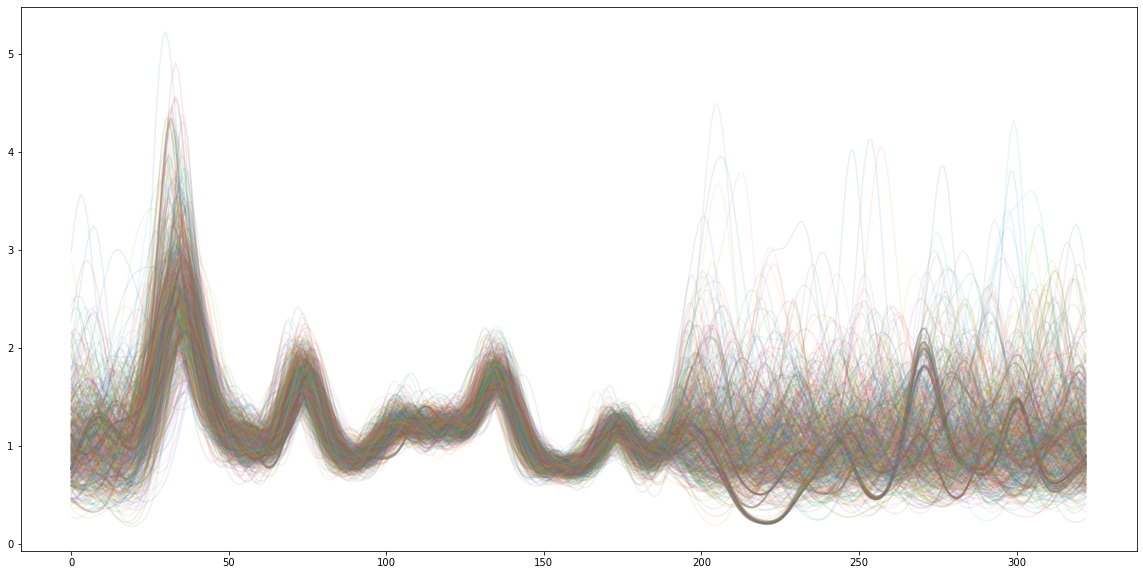

In [73]:
plt.figure(figsize=(20,10))
for j in range(800):
    plt.plot(trace["r_t"][j,:], alpha=0.1)

In [76]:
idx = [i for i in range(ndays)]

In [88]:
#bands = compute_bands(trace.get_values("new_cases", chains=0))

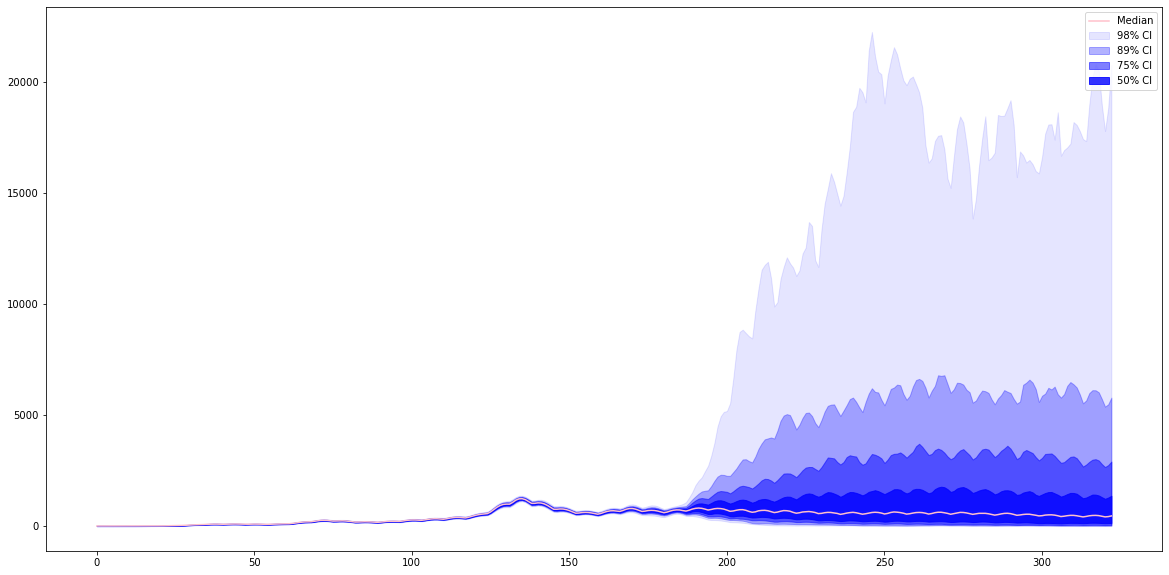

In [89]:
plt.figure(figsize=(20,10))
plt.fill_between(idx, bands[1.0], bands[99.0], alpha=0.1, color="b", label="98% CI")
plt.fill_between(idx, bands[5.5], bands[94.5], alpha=0.3, color="b", label="89% CI")
plt.fill_between(idx, bands[12.5], bands[87.5], alpha=0.5, color="b", label="75% CI")
plt.fill_between(idx, bands[25], bands[75], alpha=0.8, color="b", label="50% CI")
plt.plot(idx, bands["median"], alpha=1.0, color="pink", label="Median")


plt.legend()
plt.show()

In [109]:
import plotly.graph_objects as go
import plotly

In [112]:
def compute_bands(vals, levels=[1.0, 2.5, 5.5, 12.5, 25, 75, 87.5, 94.5, 97.5, 99.0]):
    '''
    Given an array with shape (x, y, z) where x is the dimension for samples, y is the 
    dimension for time, and z the dimension variable, computes the corresponding percentile bands for credible intervals.
    '''
    def scoreatpercentile(vals, p):
        return np.percentile(vals, p, axis=0)
    perc = {p:scoreatpercentile(vals,p) for p in levels}
    median = np.median(vals, axis=0)
    perc["median"] = median
    return perc

In [113]:
#nsamps, ndays = trace["new_cases"][:,10:]
bands = compute_bands(trace["new_cases"][:,16:])
#idx = [i for i in range(ndays)]

In [115]:
plot_data = []
idx2 = new_cases_obs.index.append(other_part.index)



#band_list = [(0.95, 0.25), (0.89, 0.4), (0.75, 0.6), (0.5, 0.9)]
#band_list = [(2.5, 97.5, 0.25), (5.5, 94.5, 0.4), (12.5, 87.5, 0.6), (25, 75, 0.9)]
band_list = [(2.5, 97.5, 0.4), (12.5, 87.5, 0.6), (25, 75, 0.9)]
for band_tup in band_list:
    b1 = go.Scatter(
            x = idx2,
            y = bands[band_tup[0]],
            name = "{:.0f}% CI".format(100-2*band_tup[0]),
            line = dict(width=3, smoothing=0.5, shape="spline", color="rgb(53, 76, 161)"),
            fill = "tonexty",
            fillcolor = "rgba(53,76,161,{})".format(band_tup[2])
    )
        
    b2 = go.Scatter(
            x = idx2,
            y = bands[band_tup[1]],
            name = None,
            line = dict(width=3, smoothing=0.5, shape="spline", color="rgb(53, 76, 161)"),
            #fill = "tonexty",
            fillcolor = "rgba(53,76,161,{})".format(band_tup[2]),
            showlegend=False,
    
    )
    plot_data.append(b2)
    plot_data.append(b1)

    
    
# Historical Data
plot_data.append(
                    go.Scatter(
                        x=new_cases_obs.index,
                        y=new_cases_obs,
                        name="Training Daily Cases",
                        #line=dict(width=3, smoothing=1.3, shape="spline"),
                        opacity=0.7,
                        line=dict(color="rgb(255,16,83)"),
                        marker=dict(
                                line=dict(color='DarkSlateGrey')
                        ),
                        mode='markers',
                        marker_symbol="star-diamond",
                        marker_size=7
            )
)

# Training Data
plot_data.append(
                    go.Scatter(
                        x=other_part.index,
                        y=other_part,
                        name="Testing Daily Cases",
                        #line=dict(width=3, smoothing=1.3, shape="spline"),
                        opacity=0.7,
                        marker=dict(
                                line=dict(color='DarkSlateGrey')
                        ),
                        mode='markers',
                        marker_symbol="star-diamond",
                        marker_size=7
            )
)
    

layout = go.Layout(
    title=dict(
        text=r"$\Large \textrm{Texas Model Fit, a 4-Week Forecast}$",
        #text="MAP Estimates of the Effective Reproduction Number R_t for Texas Counties",
        #text="Hi",
        x=0.5
        #xanchor="center",
    ),
    font=dict(size=16),
    margin=dict(pad=0),
    yaxis=dict(ticksuffix="   ",
              zeroline=False)
)


fig = go.Figure(data=plot_data, layout=layout)
fig.update_layout(
    autosize=False,
    width=1600,
    height=800,)
#fig.update_layout(yaxis=dict(range=[min_y,max_y],
#                            tickformat=".1f"))
fig.update_layout(
    font=dict(
        family="CMU Modern",
        size=24
    )
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=-0.06,
    xanchor="right",
    x=1
))

fig.update_layout(
    xaxis=dict(
        range=[datetime.datetime(2020,3,18), datetime.datetime(2020,8,31)+datetime.timedelta(days=6*7)]
    ),
    yaxis=dict(
        range=[-5, 14500]
    )
)


#fig.write_image("texas_forecast.jpg", scale=5)
#fig.write_html("texas_forecast.html")

fig.show()




In [ ]:
bands = compute_bands(trace.get_values("new_cases", chains=0))

In [79]:
trace.get_values("r_t", chains=1)

array([[1.72980794, 1.64875128, 1.55098723, ..., 0.76339112, 0.7767742 ,
        0.79738749],
       [1.60809826, 1.43417629, 1.26657431, ..., 1.32048971, 1.18567908,
        1.06585792],
       [2.23949502, 2.11033067, 1.946144  , ..., 1.2136672 , 1.15135801,
        1.08990606],
       ...,
       [1.167887  , 1.11523294, 1.07830903, ..., 1.00161994, 1.01881688,
        1.04784497],
       [1.27117179, 1.25678892, 1.25559591, ..., 0.90288368, 0.88560889,
        0.87254056],
       [1.27992582, 1.20502566, 1.16563987, ..., 1.03074371, 1.01311911,
        1.00111543]])

In [98]:
trace[0]

{'mu_log__': -2.1278701543747682,
 'pr_amplitude_interval__': -0.22037088190849155,
 'log_r_t_rotated_': array([ 1.49289553, -0.81285424, -0.38321001, -0.30079932, -0.30201981,
         0.52339564,  0.20035827, -0.6619344 ,  0.07003966,  1.83668856,
         1.57701099,  0.44080603,  0.93208218, -0.45281054,  0.52116231,
         0.85595227,  1.93162332,  0.70192136,  0.42619657, -1.02000076,
         1.38976197, -1.01337537,  1.52183311, -0.35452505,  0.91211661,
         0.71054434,  1.25947743,  1.16924363,  0.50322598,  0.38128195,
        -0.45080549,  0.99731785, -0.32220052, -0.83733647,  1.37435408,
        -0.58220201,  1.21768517, -0.62616248,  0.03550379,  0.82546292,
        -0.53370793, -0.38419429, -1.33440415, -0.73683851,  0.94362004,
         0.41108607, -0.52539048, -0.72964715, -0.13848111,  0.17310558,
        -0.95567896,  0.12089919, -0.23208524,  0.8270651 ,  0.40343528,
         0.94975776, -0.48307727,  0.30973343,  2.02720612,  1.54169237,
        -0.49608322,

In [104]:
help(trace._straces[0])

Help on NDArray in module pymc3.backends.ndarray object:

class NDArray(pymc3.backends.base.BaseTrace)
 |  NDArray(name=None, model=None, vars=None, test_point=None)
 |  
 |  NDArray trace object
 |  
 |  Parameters
 |  ----------
 |  name: str
 |      Name of backend. This has no meaning for the NDArray backend.
 |  model: Model
 |      If None, the model is taken from the `with` context.
 |  vars: list of variables
 |      Sampling values will be stored for these variables. If None,
 |      `model.unobserved_RVs` is used.
 |  
 |  Method resolution order:
 |      NDArray
 |      pymc3.backends.base.BaseTrace
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name=None, model=None, vars=None, test_point=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  close(self)
 |      Close the database backend.
 |      
 |      This is called after sampling has finished.
 |  
 |  get_values(self

In [91]:
ppc

{'_new_cases_studentT': array([[ 1.80122166e+01, -4.66039841e-01,  2.16497588e+01, ...,
          9.00746416e+02,  6.61142562e+02,  6.31120718e+02],
        [-1.83218544e+01,  2.76509952e+00,  8.87238051e-01, ...,
          5.47398857e+02,  6.34382892e+02,  6.10736463e+02],
        [ 1.54494139e+01, -5.15050569e+00,  4.43719147e+00, ...,
          4.96753134e+02,  8.38837246e+02,  5.41405576e+02],
        ...,
        [-6.02622915e+00,  5.11332762e+00, -3.37770502e+00, ...,
          7.41071447e+02,  8.36356729e+02,  8.48621320e+02],
        [ 2.35470066e+01,  2.05916072e+01, -5.38746077e-01, ...,
          4.80250644e+02,  8.62025679e+02,  6.67946758e+02],
        [ 1.08911449e+00, -2.88940143e+00,  3.46859799e+00, ...,
          7.02574923e+02,  6.92787257e+02,  2.12602408e+02]])}

In [105]:
with this_model:
    ppc = pm.sample_posterior_predictive(trace._straces[0], var_names=["new_cases"], size=5)

TypeError: Do not know how to compute number of samples for trace argument of type <class 'pymc3.backends.ndarray.NDArray'>

In [94]:
bands = compute_bands(ppc["new_cases"])

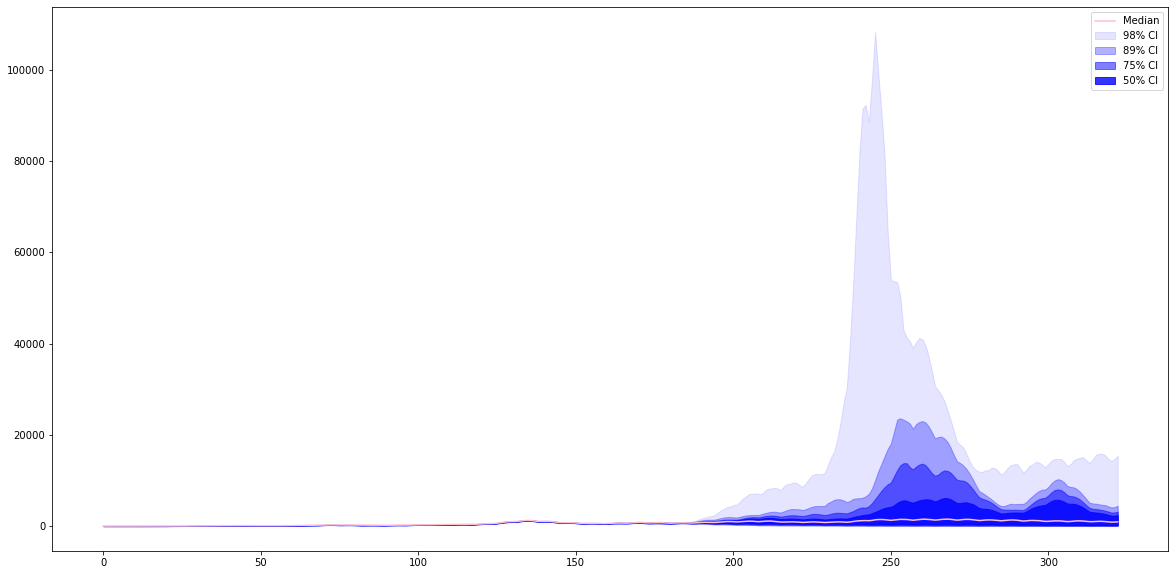

In [95]:
plt.figure(figsize=(20,10))
plt.fill_between(idx, bands[1.0], bands[99.0], alpha=0.1, color="b", label="98% CI")
plt.fill_between(idx, bands[5.5], bands[94.5], alpha=0.3, color="b", label="89% CI")
plt.fill_between(idx, bands[12.5], bands[87.5], alpha=0.5, color="b", label="75% CI")
plt.fill_between(idx, bands[25], bands[75], alpha=0.8, color="b", label="50% CI")
plt.plot(idx, bands["median"], alpha=1.0, color="pink", label="Median")


plt.legend()
plt.show()

# Other code

In [60]:
results = {}
results["Hidalgo"] = build_and_calc_map("Hidalgo")

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


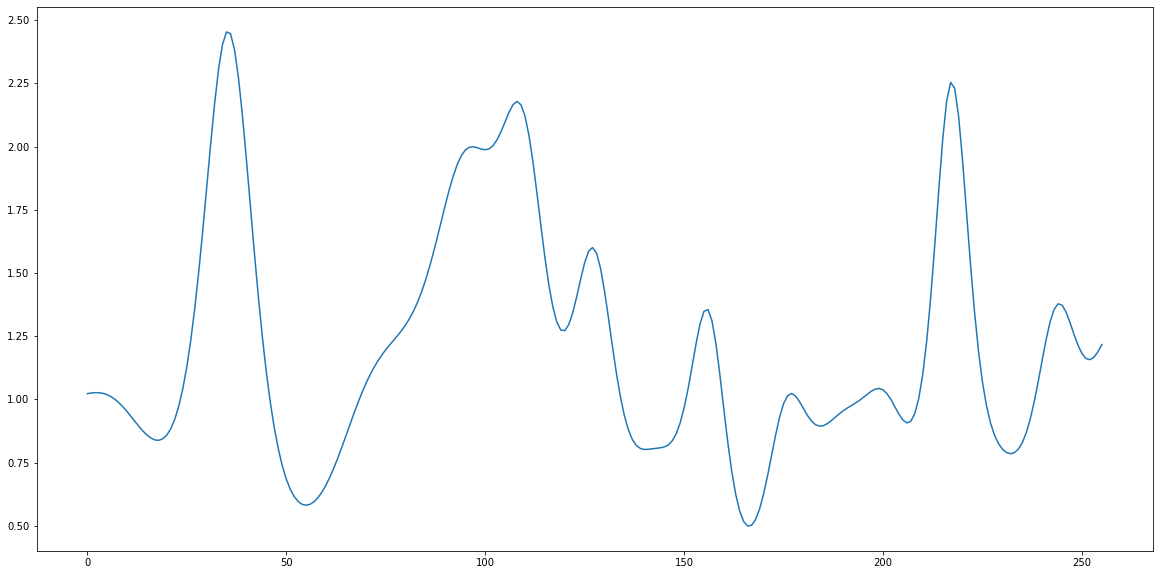

In [61]:
plt.figure(figsize=(20,10))
plt.plot(results["Hidalgo"][2]["r_t"])

In [11]:
results = {}
for county in top_ten_pop_no_county:
    print(county)
    try:
        results[county] = build_and_calc_map(county)
    except:
        print("Error: {} didn't work.".format(county))

Harris


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Dallas


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Tarrant


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Bexar


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Travis


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Collin


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Denton


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


El Paso


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Hidalgo


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Fort Bend


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [12]:
results["Texas"] = build_and_calc_map("Texas")

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


Harris
Dallas
Tarrant
Bexar
Travis
Collin
Denton
El Paso
Hidalgo
Fort Bend


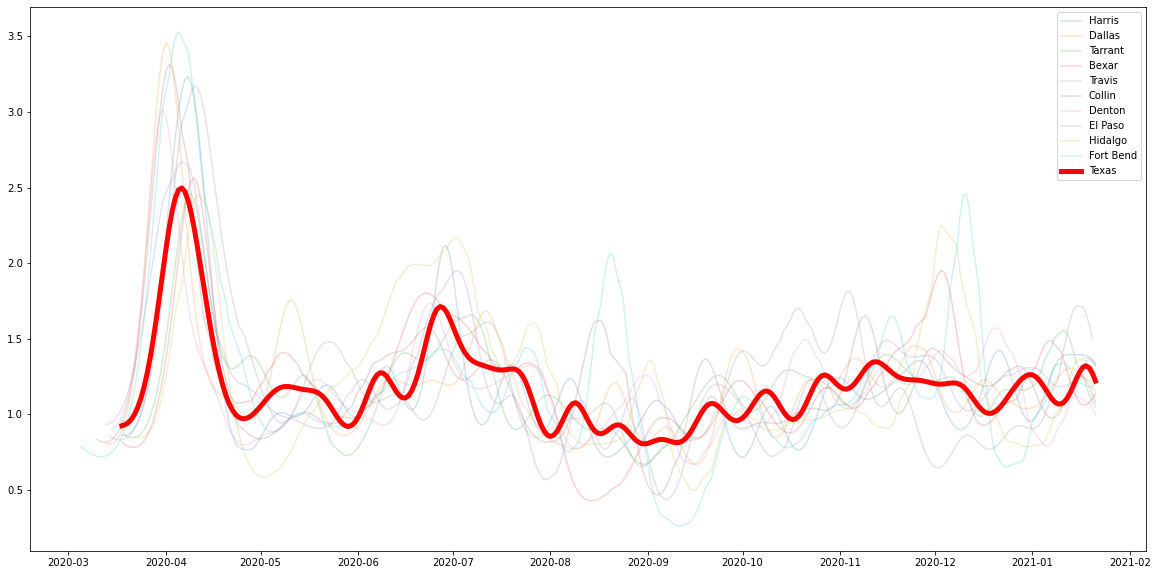

In [13]:
plt.figure(figsize=(20,10))
diff_data_sim = 16
num_days_forecast = 10
for county in top_ten_pop_no_county:
    print(county)
    try:
        county_df, county_pop, county_res = results[county]
        plt.plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label=county, alpha=0.2)
    except:
        print("{} not in results".format(county))

county_df, county_pop, county_res = results["Texas"]
plt.plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label="Texas", color="red", linewidth=5.0)
plt.legend()
plt.show()

In [14]:
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [113]:
plot_data = []
min_t = datetime.datetime(2020, 5, 5)
max_t = datetime.datetime(2020, 5, 5)



for key in reversed(results.keys()):
    if key != "Texas":
        county_df, county_pop, county_res = results[key]
        trace = go.Scatter(
                        x=county_df.index,
                        y=county_res["r_t"][diff_data_sim:-num_days_forecast],
                        name=key,
                        line=dict(width=3, smoothing=1.3, shape="spline"),
                        opacity=0.7,
                        marker=dict(
                                line=dict(color='DarkSlateGrey')
                        )
            )
        

        plot_data.append(trace)
        
        county_max_t = max(county_df.index)
        county_min_t = min(county_df.index)
        if county_max_t > max_t: max_t = county_max_t
        if county_min_t < min_t: min_t = county_min_t
        
tx1, tx2, tx3 = results["Texas"]
tx_max_t = max(tx1.index)
tx_min_t = min(tx1.index)
if tx_max_t > max_t: max_t = tx_max_t
if tx_min_t  < min_t: min_t = tx_min_t 
plot_data.append(
        go.Scatter(
                x=tx1.index,
                y=tx3["r_t"][diff_data_sim:-num_days_forecast],
                name="Texas",
                line=dict(color="rgb(204,0,53)", width=5, smoothing=1.0, shape="spline"),
            )
)

plot_data.insert(0,
        go.Scatter(
            x=pd.date_range(min_t, max_t),
            y=np.ones(len(pd.date_range(min_t, max_t))),
            line=dict(color="rgb(255,255,255,0.0)"),
            fill="tozeroy",
            fillcolor='rgba(0,128,0,0.05)',
            showlegend=False
        )
)
plot_data.insert(1,
        go.Scatter(
            x=pd.date_range(min_t, max_t),
            y=np.ones(len(pd.date_range(min_t, max_t))),
            fill="tonexty",
            fillcolor='rgba(255,0,0,0.05)',
            line=dict(color="rgb(255,255,255,0.0)"),
            showlegend=False
        )
)

# plot_data.append(
#         go.Scatter(
#             x=pd.date_range(min_t, max_t),
#             y=np.ones(len(pd.date_range(min_t, max_t))),
#             fill="tozeroy",
#             fillcolor='rgb(214, 39, 40, 0.05)'
#         )
# )

layout = go.Layout(
    title=dict(
        text=r"$\Large \textrm{MAP  Estimates  of  the  Effective  Reproduction  Number}\,\,\,\, \mathcal{R}_t \,\,\,\, \textrm{for  Texas  Counties}$",
        #text="MAP Estimates of the Effective Reproduction Number R_t for Texas Counties",
        #text="Hi",
        x=0.5
        #xanchor="center",
    ),
    font=dict(size=16),
    margin=dict(pad=0),
    yaxis=dict(ticksuffix="   ",
              zeroline=False)
)
#layout = go.Layout()
# layout = go.Layout(
#     xaxis=dict(
#         title=r'$\text{Prediction Horizon (Hours)}$'
#     ),
#     yaxis=dict(
#         title=r'$\text{Average Log Likelihood}$'
#     ),
#     title=dict(
#         text=r"$\text{Average Log Likelihood for the Different Time Horizons for the Three Methods}$",
#         x=0.5
#     ),
#     #margin=dict(l=80, r=50, t=50, b=80)
# )


max_y = 0
min_y = 0
for j, item in enumerate(plot_data):
    if max(item.y) > max_y:
        max_y = max(item.y)
    if min(item.y) < min_y:
        min_y = min(item.y)
max_y *= 1.05
min_y *= 0.95

plot_data.insert(1,
    go.Scatter(
        x = pd.date_range(min_t, max_t),
        y = max_y*np.ones(len(pd.date_range(min_t, max_t))),
        showlegend=False,
        line=dict(color="rgb(255,255,255,0.0)"),
    )
)



fig = go.Figure(data=plot_data, layout=layout)
fig.update_layout(
    autosize=False,
    width=1600,
    height=800,)
fig.update_layout(yaxis=dict(range=[min_y,max_y],
                            tickformat=".1f"))
fig.update_layout(
    font=dict(
        family="CMU Modern",
        size=24
    )
)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=-0.06,
    xanchor="right",
    x=1
))


fig.write_html(os.getcwd()+"\map_ests_r_t.html")
#fig.write_html(os.getcwd()+"\map_ests_r_t_for_web.html")
fig.write_image("map_ests_r_t.png", scale=5)

fig.show()

In [84]:
plot_data

[Scatter({
     'fill': 'tozeroy',
     'fillcolor': 'rgba(255, 0, 0, 0.1)',
     'x': array([datetime.datetime(2020, 3, 5, 0, 0),
                 datetime.datetime(2020, 3, 6, 0, 0),
                 datetime.datetime(2020, 3, 7, 0, 0), ...,
                 datetime.datetime(2021, 1, 19, 0, 0),
                 datetime.datetime(2021, 1, 20, 0, 0),
                 datetime.datetime(2021, 1, 21, 0, 0)], dtype=object),
     'y': array([1., 1., 1., ..., 1., 1., 1.])
 }),
 Scatter({
     'fill': 'tonexty',
     'fillcolor': 'rgba(0, 128, 0, 0.1)',
     'x': array([datetime.datetime(2020, 3, 5, 0, 0),
                 datetime.datetime(2020, 3, 6, 0, 0),
                 datetime.datetime(2020, 3, 7, 0, 0), ...,
                 datetime.datetime(2021, 1, 19, 0, 0),
                 datetime.datetime(2021, 1, 20, 0, 0),
                 datetime.datetime(2021, 1, 21, 0, 0)], dtype=object),
     'y': array([1., 1., 1., ..., 1., 1., 1.])
 }),
 Scatter({
     'line': {'shape': 'spline', 's

In [35]:
tx1, tx2, tx3 = results["Texas"]
trace1 = go.Scatter(
                    x=tx1.index,
                    y=tx3["r_t"][diff_data_sim:-num_days_forecast],
                    name="Texas",
                    line=dict(color="rgb(255,255,255)", width=1, smoothing=1.3, shape="spline"),
                    fill="tonexty",
                    fillcolor="rgb(204,0,53)"
        )
trace2 = go.Scatter(
                    x = tx1.index,
                    y = np.ones(len(tx1.index)),
                    line=dict(color="rgb(255,255,255)", width=5, smoothing=1.0, shape="spline"),
                    #visible=False
    
                    #fill="tonexty"
)

#data = [trace1, trace2]
data = [trace2, trace1]
layout = go.Layout()
fig = go.Figure(data=data, layout=layout)

fig.update_layout(plot_bgcolor="rgb(255,255,255)")
fig.update_layout({"xaxis":{
                    "visible" : False
                },
                  "yaxis":{
                      "visible" : False 
                  }
})
fig.update_layout(showlegend=False)

fig.show()

In [36]:
fig.write_html(os.getcwd()+"\Texas_r_t.html")

In [37]:
fig.write_image("Texas_r_t.jpg", scale=5)

# Other Code

In [ ]:
plot_data = []
for key in results.keys():
    county_df, county_pop, county_res = results[key]
    trace = go.Scatter(
                    x=county_df.index,
                    y=county_res["r_t"][diff_data_sim:-num_days_forecast],
                    name=key,
                   # line=dict(color=dcolors["Spring Green"], width=2)
        )
    
    plot_data.append(trace)

layout = go.Layout()
# layout = go.Layout(
#     xaxis=dict(
#         title=r'$\text{Prediction Horizon (Hours)}$'
#     ),
#     yaxis=dict(
#         title=r'$\text{Average Log Likelihood}$'
#     ),
#     title=dict(
#         text=r"$\text{Average Log Likelihood for the Different Time Horizons for the Three Methods}$",
#         x=0.5
#     ),
#     #margin=dict(l=80, r=50, t=50, b=80)
# )

fig = go.Figure(data=plot_data, layout=layout)
fig.show()

In [22]:
res1, res2, res3 = build_and_calc_advi("Dallas")

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


Finished [100%]: Average Loss = 2,499.2
INFO     [pymc3.variational.inference] Finished [100%]: Average Loss = 2,499.2


In [24]:
advi_res = res3.sample(1000)

In [25]:
advi_res.varnames

['mu_log__',
 'pr_amplitude_interval__',
 'log_r_t_rotated_',
 'I_begin_ratio_log',
 'delay_log',
 'weekend_factor_log',
 'offset_modulation_rad_circular__',
 'sigma_obs_log__',
 'mu',
 'pr_amplitude',
 'log_r_t',
 'r_t',
 'log_lambda_t',
 'lambda_t',
 'I_begin',
 'new_I_t',
 'S_t',
 'I_t',
 'delay',
 'delayed_cases',
 'weekend_factor',
 'offset_modulation_rad',
 'offset_modulation',
 'new_cases',
 'sigma_obs']

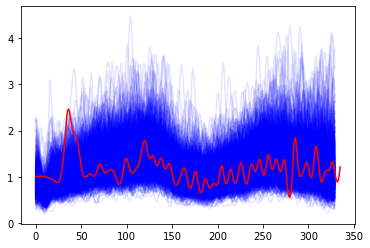

In [33]:
nsamps, nobs = advi_res["r_t"].shape
for j in range(nsamps):
    plt.plot(advi_res["r_t"][j,:], alpha = 0.1, color="blue")
plt.plot(results["Texas"][2]["r_t"], color="red")

In [31]:
results["Texas"][2]["r_t"]

array([1.00183405, 1.00435618, 1.00717585, 1.00989863, 1.01209185,
       1.01336797, 1.01344833, 1.01219201, 1.00959812, 1.00579082,
       1.00099517, 0.9954981 , 0.9895874 , 0.98347046, 0.97719034,
       0.97056688, 0.96319316, 0.95450976, 0.94396544, 0.93125395,
       0.91659053, 0.90096846, 0.88632947, 0.87560988, 0.8726824 ,
       0.88226984, 0.90991474, 0.96201621, 1.04577838, 1.1686555 ,
       1.33657808, 1.550168  , 1.79897647, 2.05627482, 2.28017793,
       2.42634215, 2.4687242 , 2.4139958 , 2.29728794, 2.16323535,
       2.04737208, 1.96750463, 1.92385421, 1.90297615, 1.88316997,
       1.84177701, 1.76378258, 1.64808225, 1.50733393, 1.361455  ,
       1.2293675 , 1.12371348, 1.04978334, 1.00700017, 0.9909169 ,
       0.99476934, 1.01064094, 1.03056992, 1.04765899, 1.05698922,
       1.0562297 , 1.04603268, 1.03019344, 1.01524481, 1.0091819 ,
       1.01945206, 1.05062662, 1.10204477, 1.16588298, 1.22714558,
       1.26779533, 1.27496693, 1.24829069, 1.20008382, 1.14820

In [91]:
results2 = {}
for county in top_ten_pop_no_county:
    print(county)
    try:
        results2[county] = build_and_calc_map(county)
    except:
        print("Error: {} didn't work.".format(county))

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Harris


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Dallas


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation



Tarrant


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Bexar


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Travis


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Collin


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Denton


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


El Paso


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Hidalgo


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp


Fort Bend


INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [92]:
results2["Texas"] = build_and_calc_map("Texas")

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


Harris
Dallas
Tarrant
Bexar
Travis
Collin
Denton
El Paso
Hidalgo
Fort Bend


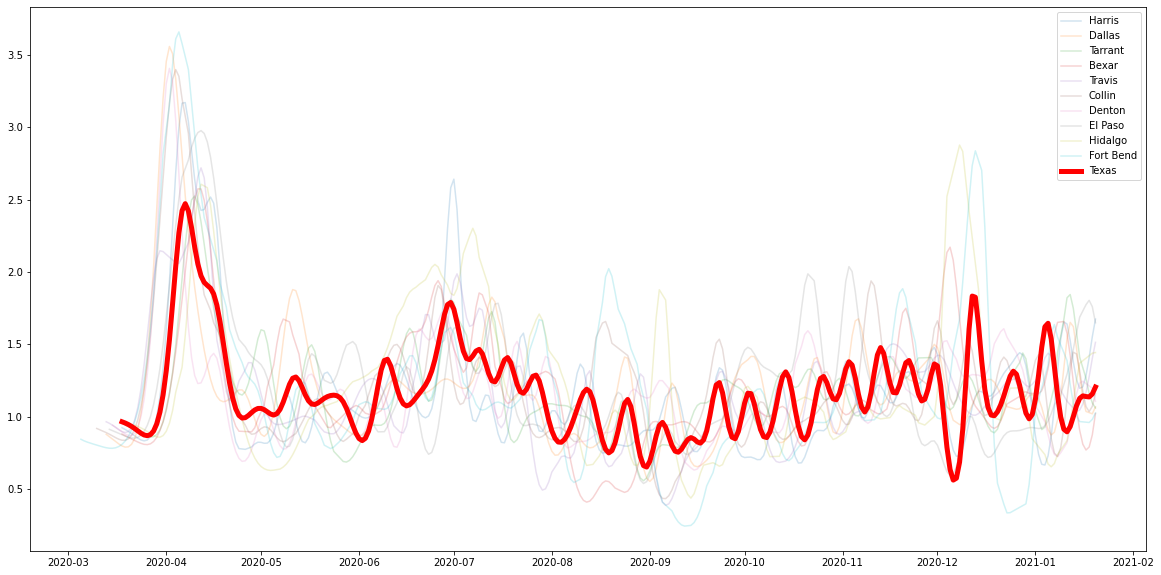

In [93]:
plt.figure(figsize=(20,10))
diff_data_sim = 16
num_days_forecast = 10
for county in top_ten_pop_no_county:
    print(county)
    try:
        county_df, county_pop, county_res = results2[county]
        plt.plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label=county, alpha=0.2)
    except:
        print("{} not in results".format(county))

county_df, county_pop, county_res = results2["Texas"]
plt.plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label="Texas", color="red", linewidth=5.0)
plt.legend()
plt.show()

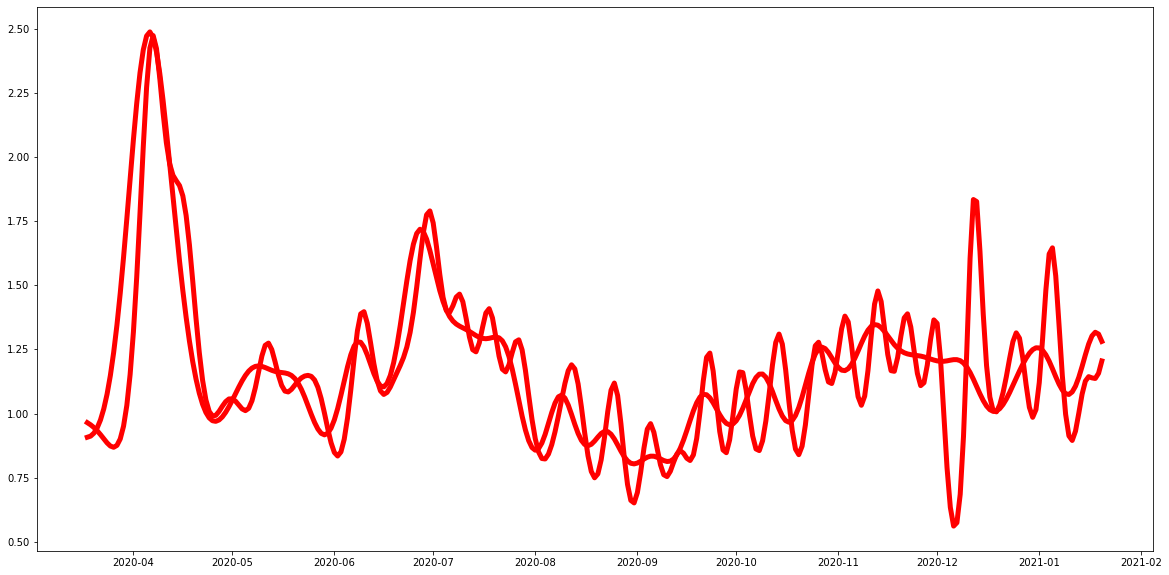

In [95]:
plt.figure(figsize=(20,10))
county_df, county_pop, county_res = results["Texas"]
plt.plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label="Texas", color="red", linewidth=5.0)
county_df, county_pop, county_res = results2["Texas"]
plt.plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label="Texas", color="red", linewidth=5.0)

# Dallas model, but with sample posterior predictive

In [97]:
# Get data
county_name = "Dallas"
new_cases_obs, county_pop = get_county_data(county_name)
    
# Setup params
diff_data_sim = 16
num_days_forecast = 10
pr_delay = 10
pr_len_scale = 7.0
#pr_len_scale = 7.0 # Length scale for the GP

# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=min(new_cases_obs.index),
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=county_pop,
    )

    # Put model together
with cov19.model.Cov19Model(**params_model) as this_model:

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # Create the array of the time dependent infection rate lambda
    #pr_len_scale = pm.Uniform('pr_len_scale', 5.0, 10.0)
    pr_amplitude = pm.Uniform('pr_amplitude', 0.1, 0.7) 
    lambda_t_log = cov19.model.lambda_t_gp(
                            mu,
                            pr_len_scale,
                            pr_amplitude,
                            #model=None,
                            name_lambda_t="lambda_t",
        )

    # This builds a decorrelated prior for I_begin for faster inference.
    prior_I = cov19.model.uncorrelated_prior_I(
            lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
        )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=pr_delay,
            pr_median_of_width=0.3,
        )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)
        
    # Now compute map
    map_est = pm.find_MAP()


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [119]:
with this_model:
    ppc = pm.sample_posterior_predictive([map_est], samples=100, var_names=["r_t"])

In [120]:
ppc["r_t"].shape

(100, 329)

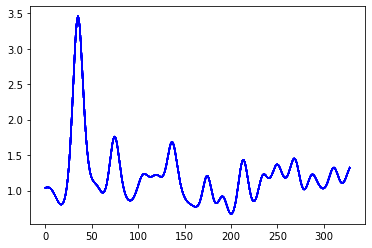

In [121]:
for j in range(ppc["r_t"].shape[0]):
    plt.plot(ppc["r_t"][j,:], alpha=0.1, color="blue")

In [18]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(
    x=[1, 2, 3, 4],
    y=[10, 11, 12, 13],
    mode='markers',
    marker=dict(size=[40, 60, 80, 100],
                color=[0, 1, 2, 3])
))

fig.show()